# LINEAR APPROXIMATIONS TO REACTION NETWORKS

**TO DO**
1. Don't understand why NONLINEAR1 gives correct Jacobian with _MDL but not _RR

## Preliminaries

In [1]:
try:
    import controlSBML as ctl
except:
    !pip import controlSBML
    import controlSBML as ctl
try:
    from symmathSBML.symmath_sbml import SymmathSBML
except:
    !pip install symmathSBML
    from symmathSBML.symmath_sbml import SymmathSBML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

import os

## Constants

In [2]:
MODELS = ["LINEAR_MDL", "NONLINEAR1_MDL", "NONLINEAR2_MDL"]

# Antimony Models

Here we present 3 variations of a sequential pathway.
* LINEAR_MDL: The kinetics result in a linear system of ODEs
* NONLINEAR1_MDL: There is one quadratic rate law, affecting $S_2$, $S_3$
* NONLINEAR2_MDL: There are two quadratic rate laws, affecting $S_1$, $S_2$,$S_3$.

## LINEAR_MDL

In [3]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
LINEAR_MDL = """
$S0 -> S1; $S0
S1 -> S2; k2*S1
S2 -> S3; k3*S2

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""

## NONLINEAR1_MDL

In [4]:
# Nonlinear model with one quadratic term
NONLINEAR1_MDL = """
$S0 -> S1; $S0
S1 -> S2; k2*S1*S1
S2 -> S3; k3*S2

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""

## NONLINEAR2_MDL

In [5]:
# Nonlinear model with two quadratic term
NONLINEAR2_MDL = """
$S0 -> S1; $S0
S1 -> S2; k2*S1*S1
S2 -> S3; k3*S2*S1

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""

## Model Plots

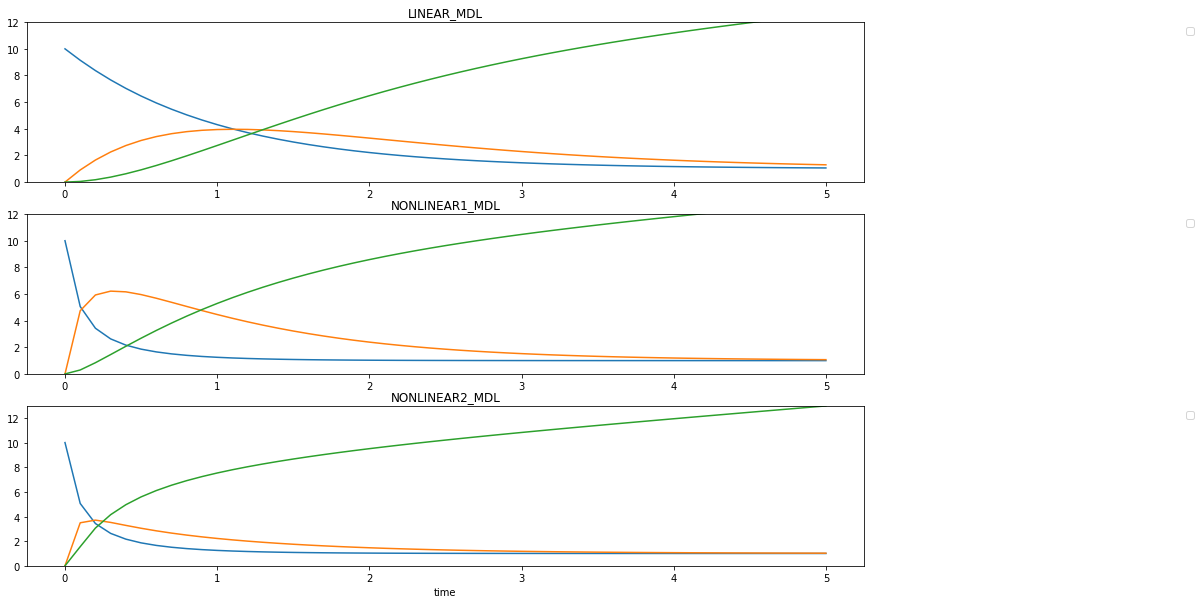

In [6]:
# Plot the three models
_, axes = plt.subplots(3, 1, figsize=(15, 10))
for idx, mdl in enumerate(MODELS):
    ctlsb = ctl.ControlSBML(eval(mdl))
    ax = axes[idx]
    if idx == len(axes) - 1:
        is_plot = True
    else:
        is_plot = False
    ctlsb.plotTrueModel(ax=ax, is_plot=is_plot, title=mdl)
    if idx < len(axes) - 1:
        ax.set_xlabel("")
    ax.set_ylim([0, 12])
    

# Helpers

In [9]:
def plotAccuracy(sbml_model, timepoints, suptitle="", is_plot=True, start_time=0, end_time=5, ymax=None, ymin=0):
    if isinstance(timepoints, float) or isinstance(timepoints, int):
        timepoints = [timepoints]
    ctlsb = ctl.ControlSBML(sbml_model)
    rr_df = ctlsb.simulateRoadrunner(start_time=start_time, end_time=end_time)
    nrow = len(timepoints)
    ncol = len(rr_df.columns)
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 5))
    axes = np.reshape(axes, (nrow, ncol))
    for irow, timepoint in enumerate(timepoints):
        linear_df = ctlsb.simulateLinearSystem(timepoint=timepoint, start_time=start_time, end_time=end_time)
        if ymax is None:
            ymax_val = max(linear_df.max().max(), rr_df.max().max())
        else:
            ymax_val = ymax
        for icol, column in enumerate(rr_df.columns):
            ax = axes[irow, icol]
            ax.plot(linear_df.index, linear_df[column], color="red")
            ax.plot(rr_df.index, rr_df[column], color="blue")
            ax.scatter([timepoint], [ymin], s=40, marker="o", color="g")
            ax.set_xlim([start_time, end_time])
            ax.set_ylim([0, ymax_val])
            if irow < nrow - 1:
                ax.set_xticklabels([])
            if irow == 0:
                ax.set_title(column)
                if icol == 0:
                    ax.text(start_time-3, 0.75*ymax_val, "Jacobian Time")
                    ax.legend(["linear", "nonlinear"])
            if icol > 0:
                ax.set_yticklabels([])
            else:
                ax.text(start_time-2, ymax_val/2, "%2.1f" % timepoint)
    plt.suptitle(suptitle)
    if is_plot:
        plt.show()
    else:
        plt.close()
    
# Tests
suptitle = "NONLINEAR1_MDL"
plotAccuracy(NONLINEAR1_MDL, [0, 1, 2, 3], suptitle=suptitle, start_time=2, ymax=20,  is_plot=False)
print("OK!")

OK!


# Accuracy of Linear Model: Sequential Pathway

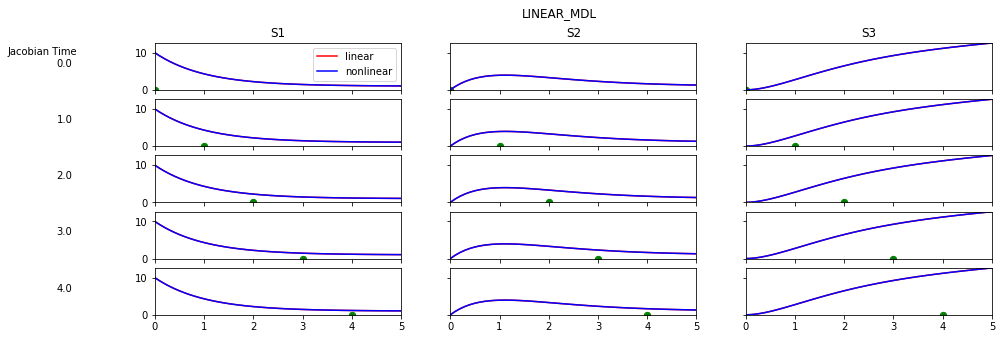

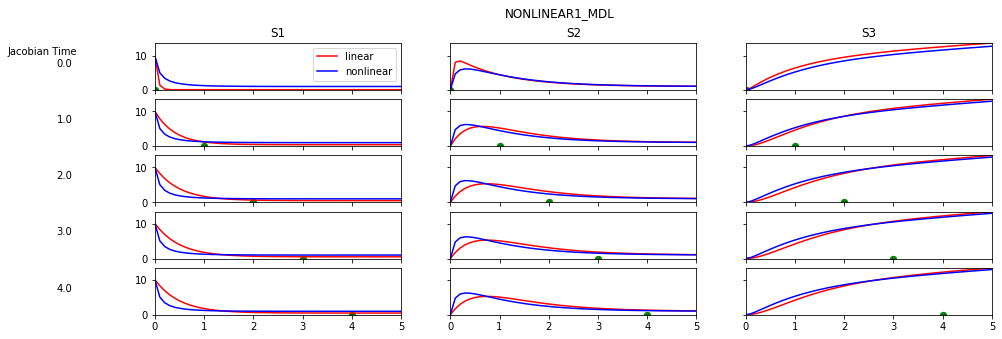

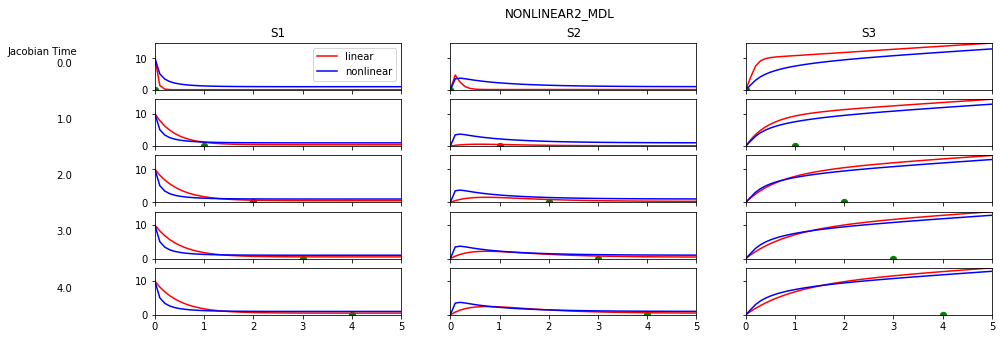

In [10]:
timepoints = range(5)
for name in MODELS:
    mdl = eval(name)
    plotAccuracy(mdl, timepoints, suptitle=name, is_plot=True)

In [11]:
try:
    symmath = SymmathSBML(NONLINEAR2_MDL)
    symmath.jacobian_df
except:
    pass

**Notes**
1. For S0, the time at which the Jacobian is calculated doesn't matter since $\frac {\partial S_0}{S_n}$ is a constant (0).
1. $S_1$, $S_2$, $S_3$ have non-constant partial derivatives and so their Jacobian will change with the timepoint.

In [12]:
for mdl in MODELS:
    print(mdl)
    symmath = SymmathSBML(eval(mdl))
    jacobian = symmath.getJacobian()
    print(jacobian)

LINEAR_MDL
                   S0                 S1                 S2 S3
S0  -1.00000000000000                  0                  0  0
S1   1.00000000000000  -1.00000000000000                  0  0
S2                  0   1.00000000000000  -1.00000000000000  0
S3                  0                  0   1.00000000000000  0
NONLINEAR1_MDL
                   S0       S1                 S2 S3
S0  -1.00000000000000        0                  0  0
S1   1.00000000000000  -2.0*S1                  0  0
S2                  0   2.0*S1  -1.00000000000000  0
S3                  0        0   1.00000000000000  0
NONLINEAR2_MDL
                   S0               S1       S2 S3
S0  -1.00000000000000                0        0  0
S1   1.00000000000000          -2.0*S1        0  0
S2                  0  2.0*S1 - 1.0*S2  -1.0*S1  0
S3                  0           1.0*S2   1.0*S1  0


# Controllability

In [13]:
B = np.array([1, 0, 0])
B = np.reshape(B, (3, 1))
B

array([[1],
       [0],
       [0]])

## Issues
1. Many models wouldn't load in symmathSBML
1. Seems that state includes some elements that are not species, BCK2
1. Why is there a difference between the length of the state_vec and the length of species_names?
1. Need getCurrentState

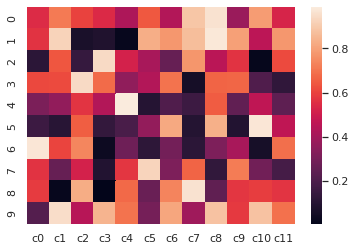

In [14]:
import numpy as np; np.random.seed(0)
import pandas as pd
import seaborn as sns; sns.set_theme()
ncol = 12
uniform_data = np.random.rand(10, ncol)
columns = ["c%d" % n for n in range(ncol)]
df = pd.DataFrame(uniform_data, columns=columns)
ax = sns.heatmap(df)


# Wolf Model

In [15]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml")

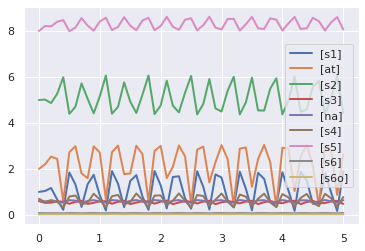

In [16]:
rr.plot(rr.simulate())

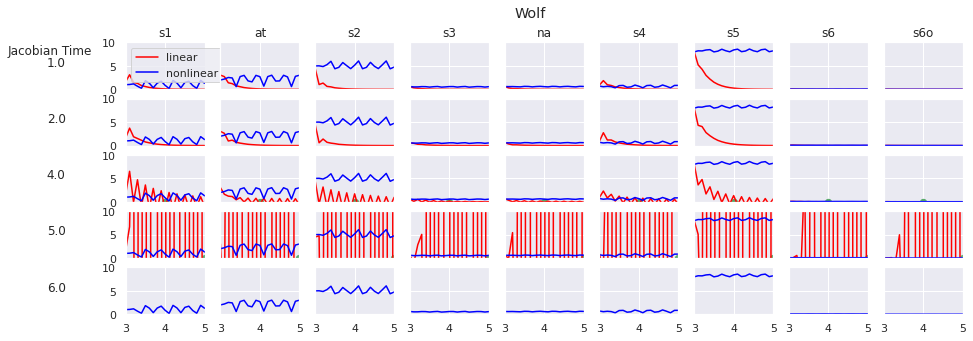

In [17]:
plotAccuracy(rr, [1, 2, 4, 5, 6], suptitle="Wolf", start_time=3, end_time=5, ymax=10)

In [18]:
ctlsb = ctl.ControlSBML(rr)